In [1]:
# ==============================================
# 2D Toy Example
# ==============================================

# Consider first a simple linear model y = sign(<~a,x>+~b) and norm bounded
# additive threat model. (I.e. ~a = a + delta_a | ~b = b + delta_b  with
# ||delta_a||_2 <= t_1 and ||delta_b||_2 <= t_2)

In [2]:
# --------- Imports -------------------
import numpy as np
import matplotlib.pyplot as plt
from plnn import PLNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import utilities as utils
import copy
import math

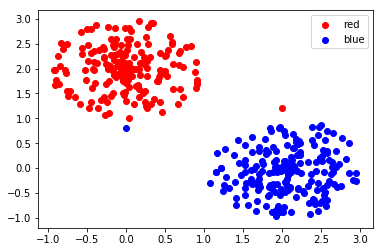

In [3]:
#---------- Load Data -----------------
# Simple, linearly seperable data plus two manually added points


def uniform_circle_samples(c, r, numpts):
    a_list = [r*np.asarray([rand_r*np.cos(theta), rand_r*np.sin(theta)]) + c for theta, rand_r
            in zip(np.random.uniform(-np.pi, np.pi, numpts), np.random.uniform(0, 1, numpts))]
    return np.asarray(a_list)
    
# Points drawn uniformly from two circles
numpts = 200
c1 = np.asarray([0,2]); c2 = np.asarray([2,0])
X1 = uniform_circle_samples(c1, 1, numpts)
X2 = uniform_circle_samples(c2, 1, numpts)

# Two manually chosen points added
epsilon = 0.2
x_blu = np.asarray([0, 1-epsilon]); x_red = np.asarray([2, 1+epsilon])
X1 = np.vstack([X1, x_red]); X2 = np.vstack([X2, x_blu])

# Create Data with Labels
X = torch.Tensor(np.vstack([X1, X2]))
y = torch.Tensor(np.hstack([np.zeros([1, numpts+1]), np.ones([1, numpts+1])])[0]).long()

# Visualize Data
plt.scatter(X1[:,0], X1[:,1], label='red', c='red')
plt.scatter(X2[:,0], X2[:,1], label='blue', c='blue')
plt.legend()

In [4]:
#---------- Load Simple Network  -----------------
layer_sizes = [2, 10,10, 2]
network = PLNN(layer_sizes)
net = network.net

Network Layer Sizes
[2, 10, 10, 2]


===============Training Network============
final error:  tensor(0.0050)


/home/justin/.conda/envs/DeepL/lib/python3.7/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


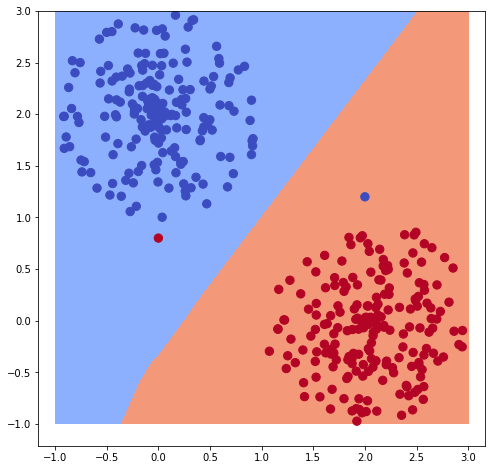

In [5]:
#---------- Train and Attack Via Gradient Descent -----------------

# Train NN:
print('===============Training Network============')
numsteps = 3000
opt = optim.SGD(net.parameters(), lr=1e-3)
for i in range(numsteps):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    opt.zero_grad()
    (l).backward()
    opt.step() 
print('final error: ', err)

# Visualize Classifier
XX, YY = np.meshgrid(np.linspace(-1, 3, 100), np.linspace(-1, 3, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()
_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")

# Copy Network Weights
network_copy = copy.deepcopy(network)


In [6]:
def as_numpy(tensor_or_array):
    """ If given a tensor or numpy array returns that object cast numpy array
    """

    if isinstance(tensor_or_array, torch.Tensor):
        tensor_or_array = tensor_or_array.cpu().detach().numpy()
    return tensor_or_array


def adv_projection_step(network_copy, network, bound_ratios, norm='l2'):
    """Project current gradient on norm bounded constraints. Bound of each parameter
       given as a fraction of the norm of the original parameter (w.r.t given norm).
       Fraction value given per layer through bound_ratios"""

    if norm == 'l2':
        for fc_copy, fc, ratio in zip(network_copy.fcs, network.fcs, bound_ratios):
            for param_copy, param in zip(fc_copy.parameters(), fc.parameters()):
                if len(np.shape(param)) > 1 :
                    param_copy_np = as_numpy(param_copy)
                    diff = as_numpy(param - param_copy)
                    diff_norm = np.linalg.norm(diff)
                    c = ratio*np.linalg.norm(param_copy_np)/(diff_norm + 1e-)
                    param.data = torch.Tensor(param_copy_np + diff*c)
                    if not math.isnan(c):
                        param.data = torch.Tensor(param_copy_np + diff*c)
                    else:
                        param.data = copy.deepcopy(param_copy.data)
                else:
                    param.data = copy.deepcopy(param_copy.data)
    else:
        raise NotImplementedError
        
def get_labels_hat(network, data):
    labels = []
    pre_y = network(data)
    for elem in pre_y:
        if elem[0] > elem[1]:
            labels.append(0)
        else:
            labels.append(1)
    return labels

===============Attacking Network============
Final error:  tensor(0.9776)


(-1.0, 3.0, -1.2114217646000989, 3.0)

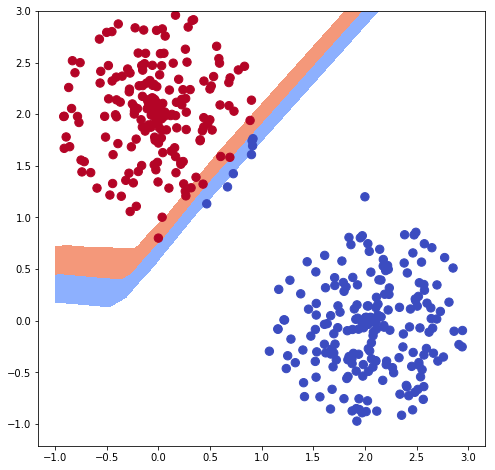

In [7]:
# ---------- Attack NN -----------------:
opt = optim.Rprop(net.parameters(), lr=1e-3)
print('===============Attacking Network============')
numsteps = 100
for i in range(numsteps):
    out = net(Variable(X))
    l = -1*nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    opt.zero_grad()
    (l).backward()
    opt.step()
    adv_projection_step(network_copy, network, [0.00000, 0.00])
print('Final error: ', err)
        
# Visualize Classifier
XX, YY = np.meshgrid(np.linspace(-1, 3, 100), np.linspace(-1, 3, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()
_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
y_hat = get_labels_hat(net, X)
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y_hat, cmap="coolwarm", s=70)
ax.axis("equal")

===============Training Network============
final error:  tensor(0.)


(-1.0, 3.0, -1.2114217646000989, 3.0)

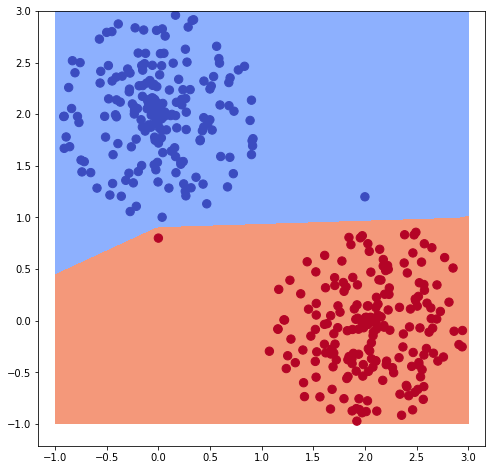

In [8]:
#---------- Train and Attack Via Gradient Descent -----------------

# Train NN:
print('===============Training Network============')
numsteps = 100
for i in range(numsteps):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    opt.zero_grad()
    (l).backward()
    opt.step() 
print('final error: ', err)

# Visualize Classifier
XX, YY = np.meshgrid(np.linspace(-1, 3, 100), np.linspace(-1, 3, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()
_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")



In [9]:
all([True, False, True])

False